# Section 3: Supervised Learning Reviews

If we check the distribution of the polarity pattern of reviews according to the rating score, we can see high overlapping of score 2 in 1 and score 4 in 5, and a trend of score 3 to overlap positive and negative cloud of scores. The concept of a positive and negative connotation is more intuitive than the difference between 1 and 2 scores or between 4 and 5 scores. Together they enclose more fundamental categories: positive and negative reviews. After to inspect reviews with 3 stars, it was decided to ignore them in this section, since the criteria to put 3 stars to a slightly positive or slightly negative review is completely subjective (depends absolutely on the customers perspective).

Next analysis solves a binary classification problem of positive and negatives reviews.

#### Importing relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
#import xgboost as xgb

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Additional packages for the last section (compare different models)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#### Importing Polarity features vectors

In [5]:
data = pd.read_csv('preprocessing_ml/features_extended_vectors.csv')

In [6]:
data_copy = data.copy()
data_copy.shape

(1195, 18)

#### Re-label score in reviews

Change the labels in rating column. Scores less than 3 stars implies negative reviews (-1) and more than 3 stars correspond with positive reviews (1). Output vector doesn't consider reviews with 3 stars as score.

In [7]:
data_copy = data_copy[(data_copy.rating != 3)]

In [8]:
data_copy.loc[data_copy.rating > 3, 'label'] = 1
#data_copy.loc[data_copy.rating == 3, 'label'] = 0
data_copy.loc[data_copy.rating < 3, 'label'] = -1

In [9]:
data_copy.groupby('label').count()

,id review,beans,roast,drinks,barista,coffee_sentiment,go,do,out,ambient,price,place_sentiment,baked,lunch,breakfast,snacks,food_sentiment,rating
label,,,,,,,,,,,,,,,,,,
-1.0,468,468,468,468,468,468,468,468,468,468,468,468,468,468,468,468,468,468
1.0,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400


#### Determine best features 

A statistic chi-squared test provided by SelectKBest was applied to extract the 12 features more strongly related to the label or output variable of the features vector. Tests measure dependence between the features and output variable and lower scores represent independence and then useless for the classification.

In [10]:
X_customers = data.loc[:, 'beans':'food_sentiment']
y = data['rating']

#apply SelectKBest class to extract top 12 best features
bestfeatures = SelectKBest(score_func=chi2, k=12)
fit = bestfeatures.fit(X_customers,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_customers.columns)

#concat dataFrames
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(16,'Score'))  #print all features

               Specs     Score
15    food_sentiment  5.413870
10   place_sentiment  3.445256
4   coffee_sentiment  2.620229
13         breakfast  2.499367
8            ambient  2.215618
11             baked  1.955993
6                 do  1.552491
7                out  1.171203
9              price  1.068263
3            barista  1.065758
2             drinks  0.850705
5                 go  0.815048
14            snacks  0.663182
12             lunch  0.562838
0              beans  0.165401
1              roast  0.086785


In [11]:
y = data_copy['label']
X = data_copy.drop(columns=['id review','rating','label','roast','beans','lunch','snacks'], axis=1)

In [12]:
X.head()

,drinks,barista,coffee_sentiment,go,do,out,ambient,price,place_sentiment,baked,breakfast,food_sentiment
0,0.006592,0.035820,0.023637,0.021750,0.018515,0.013802,0.019852,0.026701,0.054124,0.010079,0.019629,0.010274
1,0.010050,0.071520,0.023314,0.021246,0.009905,0.009568,0.006889,0.000000,0.018564,0.007172,0.105613,0.014556
2,0.049303,0.012584,0.000000,0.008524,0.006201,0.011497,0.013930,0.015453,0.019403,0.004650,0.009918,0.012436
3,0.034185,0.008770,0.061663,0.028638,0.026911,0.017050,0.028824,0.047673,0.079402,0.006407,0.007538,0.048738
4,0.018187,0.031536,0.025599,0.020271,0.017863,0.013395,0.011943,0.016992,0.046772,0.069600,0.032104,0.037079


Split training and testing data:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=21)

In [14]:
#Inspecting performance adding estimators:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      objective='binary:hinge', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=1)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[1]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[2]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[3]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[4]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[5]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[6]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[7]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[8]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validation_1-error:0.586207
[9]	validation_0-auc:0.5	validation_0-error:0.527378	validation_1-auc:0.5	validati

[78]	validation_0-auc:0.730241	validation_0-error:0.283862	validation_1-auc:0.644608	validation_1-error:0.402299
[79]	validation_0-auc:0.738438	validation_0-error:0.275216	validation_1-auc:0.642565	validation_1-error:0.402299
[80]	validation_0-auc:0.738121	validation_0-error:0.275216	validation_1-auc:0.642565	validation_1-error:0.402299
[81]	validation_0-auc:0.741903	validation_0-error:0.270893	validation_1-auc:0.642565	validation_1-error:0.402299
[82]	validation_0-auc:0.743111	validation_0-error:0.269452	validation_1-auc:0.647467	validation_1-error:0.396552
[83]	validation_0-auc:0.742953	validation_0-error:0.269452	validation_1-auc:0.647467	validation_1-error:0.396552
[84]	validation_0-auc:0.749783	validation_0-error:0.262248	validation_1-auc:0.667075	validation_1-error:0.373563
[85]	validation_0-auc:0.752674	validation_0-error:0.259366	validation_1-auc:0.662173	validation_1-error:0.37931
[86]	validation_0-auc:0.753882	validation_0-error:0.257925	validation_1-auc:0.667075	validation_1

[151]	validation_0-auc:0.810884	validation_0-error:0.195965	validation_1-auc:0.720588	validation_1-error:0.298851
[152]	validation_0-auc:0.81225	validation_0-error:0.194524	validation_1-auc:0.720588	validation_1-error:0.298851
[153]	validation_0-auc:0.81225	validation_0-error:0.194524	validation_1-auc:0.720588	validation_1-error:0.298851
[154]	validation_0-auc:0.81225	validation_0-error:0.194524	validation_1-auc:0.720588	validation_1-error:0.298851
[155]	validation_0-auc:0.813616	validation_0-error:0.193084	validation_1-auc:0.720588	validation_1-error:0.298851
[156]	validation_0-auc:0.813616	validation_0-error:0.193084	validation_1-auc:0.72549	validation_1-error:0.293103
[157]	validation_0-auc:0.816348	validation_0-error:0.190202	validation_1-auc:0.72549	validation_1-error:0.293103
[158]	validation_0-auc:0.816348	validation_0-error:0.190202	validation_1-auc:0.72549	validation_1-error:0.293103
[159]	validation_0-auc:0.816348	validation_0-error:0.190202	validation_1-auc:0.730392	validati

[224]	validation_0-auc:0.846087	validation_0-error:0.158501	validation_1-auc:0.733252	validation_1-error:0.281609
[225]	validation_0-auc:0.846087	validation_0-error:0.158501	validation_1-auc:0.733252	validation_1-error:0.281609
[226]	validation_0-auc:0.846087	validation_0-error:0.158501	validation_1-auc:0.733252	validation_1-error:0.281609
[227]	validation_0-auc:0.847453	validation_0-error:0.157061	validation_1-auc:0.733252	validation_1-error:0.281609
[228]	validation_0-auc:0.847453	validation_0-error:0.157061	validation_1-auc:0.733252	validation_1-error:0.281609
[229]	validation_0-auc:0.847453	validation_0-error:0.157061	validation_1-auc:0.733252	validation_1-error:0.281609
[230]	validation_0-auc:0.848819	validation_0-error:0.15562	validation_1-auc:0.733252	validation_1-error:0.281609
[231]	validation_0-auc:0.850185	validation_0-error:0.154179	validation_1-auc:0.733252	validation_1-error:0.281609
[232]	validation_0-auc:0.850185	validation_0-error:0.154179	validation_1-auc:0.733252	val

[297]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.731209	validation_1-error:0.281609
[298]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.731209	validation_1-error:0.281609
[299]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.731209	validation_1-error:0.281609
[300]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.731209	validation_1-error:0.281609
[301]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.731209	validation_1-error:0.281609
[302]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.724265	validation_1-error:0.287356
[303]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.724265	validation_1-error:0.287356
[304]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.724265	validation_1-error:0.287356
[305]	validation_0-auc:0.867628	validation_0-error:0.135447	validation_1-auc:0.729167	va

[370]	validation_0-auc:0.892376	validation_0-error:0.10951	validation_1-auc:0.748775	validation_1-error:0.258621
[371]	validation_0-auc:0.89101	validation_0-error:0.110951	validation_1-auc:0.748775	validation_1-error:0.258621
[372]	validation_0-auc:0.892376	validation_0-error:0.10951	validation_1-auc:0.748775	validation_1-error:0.258621
[373]	validation_0-auc:0.892535	validation_0-error:0.10951	validation_1-auc:0.748775	validation_1-error:0.258621
[374]	validation_0-auc:0.892535	validation_0-error:0.10951	validation_1-auc:0.748775	validation_1-error:0.258621
[375]	validation_0-auc:0.89101	validation_0-error:0.110951	validation_1-auc:0.748775	validation_1-error:0.258621
[376]	validation_0-auc:0.89101	validation_0-error:0.110951	validation_1-auc:0.748775	validation_1-error:0.258621
[377]	validation_0-auc:0.893901	validation_0-error:0.108069	validation_1-auc:0.748775	validation_1-error:0.258621
[378]	validation_0-auc:0.895267	validation_0-error:0.106628	validation_1-auc:0.748775	validatio

[443]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[444]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[445]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[446]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[447]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[448]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[449]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[450]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	validation_1-error:0.258621
[451]	validation_0-auc:0.910452	validation_0-error:0.090778	validation_1-auc:0.748775	va

[515]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.753676	validation_1-error:0.252874
[516]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.753676	validation_1-error:0.252874
[517]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.743873	validation_1-error:0.264368
[518]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.743873	validation_1-error:0.264368
[519]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.743873	validation_1-error:0.264368
[520]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.743873	validation_1-error:0.264368
[521]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.743873	validation_1-error:0.264368
[522]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.736928	validation_1-error:0.270115
[523]	validation_0-auc:0.92443	validation_0-error:0.076369	validation_1-auc:0.74183	validation_1

[588]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[589]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.727941	validation_1-error:0.275862
[590]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[591]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[592]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[593]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[594]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[595]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_1-error:0.281609
[596]	validation_0-auc:0.938408	validation_0-error:0.06196	validation_1-auc:0.723039	validation_

[661]	validation_0-auc:0.954068	validation_0-error:0.04611	validation_1-auc:0.723039	validation_1-error:0.281609
[662]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[663]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[664]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[665]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[666]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[667]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[668]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	validation_1-error:0.281609
[669]	validation_0-auc:0.955435	validation_0-error:0.044669	validation_1-auc:0.723039	val

[733]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[734]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[735]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[736]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[737]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[738]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[739]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[740]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	validation_1-error:0.270115
[741]	validation_0-auc:0.970045	validation_0-error:0.030259	validation_1-auc:0.732843	va

[805]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.725899	validation_1-error:0.275862
[806]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.725899	validation_1-error:0.275862
[807]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.725899	validation_1-error:0.275862
[808]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.732843	validation_1-error:0.270115
[809]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.727941	validation_1-error:0.275862
[810]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.725899	validation_1-error:0.275862
[811]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.720997	validation_1-error:0.281609
[812]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.720997	validation_1-error:0.281609
[813]	validation_0-auc:0.974144	validation_0-error:0.025937	validation_1-auc:0.720997	va

[877]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[878]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[879]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[880]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[881]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[882]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[883]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.725899	validation_1-error:0.275862
[884]	validation_0-auc:0.984181	validation_0-error:0.01585	validation_1-auc:0.718954	validation_1-error:0.281609
[885]	validation_0-auc:0.985547	validation_0-error:0.014409	validation_1-auc:0.720997	validation

[950]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[951]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[952]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[953]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[954]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[955]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[956]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[957]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_1-error:0.270115
[958]	validation_0-auc:0.98828	validation_0-error:0.011527	validation_1-auc:0.732843	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='binary:hinge',
       random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.9, verbosity=1)

We note that after 560 estimators the error begins to increase. Thus, we define 550 estimators for the model:

In [15]:
xg = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=550, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=5)

In [16]:
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=5, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=550, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8, verbosity=1)

In [17]:
y_pred = xg.predict(X_test)
predictions = [round(value) for value in y_pred]

In [18]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.01%


#### Comparing XGBoost with other methods

In this section, we compare a boosting method (Gradient Boost), an averaging method (Random Forest) and XGBoost. Additionally, we build a pipeline, adding a Linear Regression model after of every ensemble model. The analysis considers 5 estimators for the Gradient Boost and Random Forest methods:

In [19]:
#Adding the XGBoost analysis to the original source 
#(https://scikit-learn.org/stable/modules/ensemble.html) 
# we can build the following ROC curve:

np.random.seed(10)

n_estimator = 5

# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42)

# The xgboost model by itself
xg.fit(X_train, y_train)
y_pred_xg = xg.predict_proba(X_test)[:, 1]
fpr_xg, tpr_xg, _ = roc_curve(y_test, y_pred_xg)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder(categories='auto')
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder(categories='auto')
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

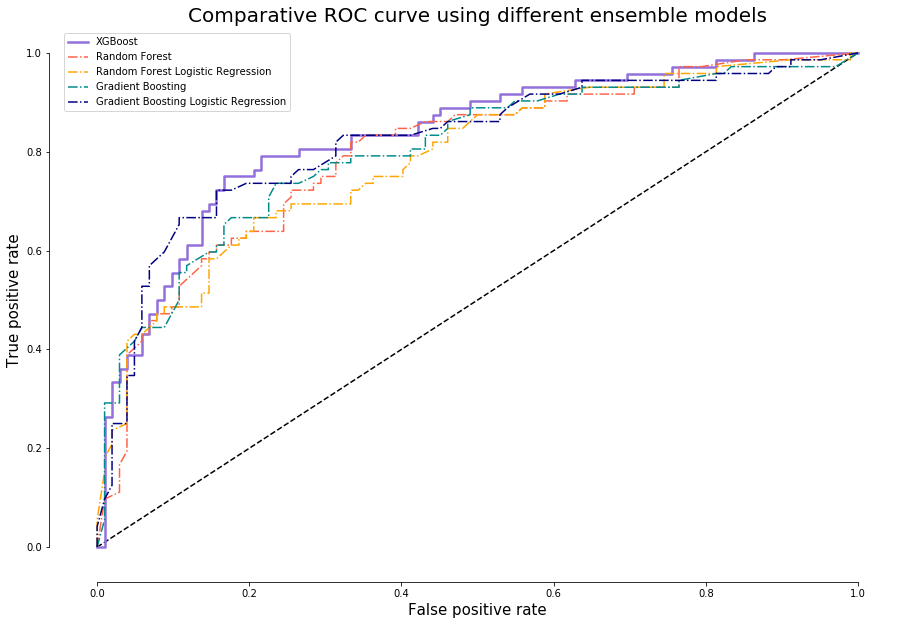

In [20]:
f, ax = plt.subplots(figsize=(15, 10))
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr_xg, tpr_xg, label='XGBoost', color='mediumpurple', linestyle='-', linewidth=2.5)
_ = plt.plot(fpr_rf, tpr_rf, label='Random Forest', color='tomato', linestyle='-.')
_ = plt.plot(fpr_rf_lm, tpr_rf_lm, label='Random Forest Logistic Regression', color='orange', linestyle='-.')
_ = plt.plot(fpr_grd, tpr_grd, label='Gradient Boosting', color='darkcyan', linestyle='-.')
_ = plt.plot(fpr_grd_lm, tpr_grd_lm, label='Gradient Boosting Logistic Regression', color='navy', linestyle='-.')
_ = plt.xlabel('False positive rate', fontsize=15)
_ = plt.ylabel('True positive rate', fontsize=15)
_ = plt.title('Comparative ROC curve using different ensemble models', fontsize=20)
_ = plt.legend(loc='best')
_ = sns.despine(offset=10, trim=True)
plt.show()

In [22]:
print('AUC XGBoost : {}'.format(roc_auc_score(y_test, y_pred_xg)))

AUC XGBoost : 0.8346949891067539


In [23]:
print('AUC Random Forest : {}'.format(roc_auc_score(y_test, y_pred_rf)))

AUC Logistic Regression Random Forest : 0.7971813725490196


In [24]:
print('AUC Random Forest Logistic Regression : {}'.format(roc_auc_score(y_test, y_pred_rf_lm)))

AUC Random Forest : 0.7850626361655774


In [25]:
print('AUC Gradient Boosting : {}'.format(roc_auc_score(y_test, y_pred_grd)))

AUC Logistic Regression Gradient Boosting : 0.8022875816993463


In [26]:
print('AUC Gradient Boosting Logistic Regression : {}'.format(roc_auc_score(y_test, y_pred_grd_lm)))

AUC Gradient Boosting : 0.8216230936819172


In [27]:
predictions = [round(value) for value in y_pred_xg]
predictions = [-1 if p ==0 else 1 for p in predictions]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy XGBoost: %.2f%%" % (accuracy * 100.0))
confusion_matrix(y_test, predictions)

Accuracy XGBoost: 77.01%


array([[77, 25],
       [15, 57]])

In [28]:
predictions = [round(value) for value in y_pred_rf_lm]
predictions = [-1 if p ==0 else 1 for p in predictions]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy Logistic Regression Random Forest: %.2f%%" % (accuracy * 100.0))
confusion_matrix(y_test, predictions)

Accuracy Logistic Regression Random Forest: 71.26%


array([[74, 28],
       [22, 50]])

In [29]:
predictions = [round(value) for value in y_pred_rf]
predictions = [-1 if p ==0 else 1 for p in predictions]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy Random Forest: %.2f%%" % (accuracy * 100.0))
confusion_matrix(y_test, predictions)

Accuracy Random Forest: 71.84%


array([[72, 30],
       [19, 53]])

In [30]:
predictions = [round(value) for value in y_pred_grd]
predictions = [-1 if p ==0 else 1 for p in predictions]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy Gradient Boosting: %.2f%%" % (accuracy * 100.0))
confusion_matrix(y_test, predictions)

Accuracy Gradient Boosting: 75.29%


array([[78, 24],
       [19, 53]])

In [31]:
predictions = [round(value) for value in y_pred_grd_lm]
predictions = [-1 if p ==0 else 1 for p in predictions]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy Logistic Gradient Boosting: %.2f%%" % (accuracy * 100.0))
confusion_matrix(y_test, predictions)

Accuracy Logistic Gradient Boosting: 73.56%


array([[73, 29],
       [17, 55]])